# NEAT solving XOR

In [1]:
!pip install neat-python
!pip install graphviz

/bin/bash: /home/marcel/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
/bin/bash: /home/marcel/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


## Visualization

Some helper classes for visualization purpose.

In [27]:
import warnings

import graphviz
import matplotlib.pyplot as plt
import numpy as np


def plot_stats(statistics, ylog=False, view=True, filename='./neat/avg_fitness.svg'):
    """ Plots the population's average and best fitness. """
    if plt is None:
        warnings.warn("This display is not available due to a missing optional dependency (matplotlib)")
        return

    generation = range(len(statistics.most_fit_genomes))
    best_fitness = [c.fitness for c in statistics.most_fit_genomes]
    avg_fitness = np.array(statistics.get_fitness_mean())
    stdev_fitness = np.array(statistics.get_fitness_stdev())

    plt.plot(generation, avg_fitness, 'b-', label="average")
    plt.plot(generation, avg_fitness - stdev_fitness, 'g-.', label="-1 sd")
    plt.plot(generation, avg_fitness + stdev_fitness, 'g-.', label="+1 sd")
    plt.plot(generation, best_fitness, 'r-', label="best")

    plt.title("Population's average and best fitness")
    plt.xlabel("Generations")
    plt.ylabel("Fitness")
    plt.grid()
    plt.legend(loc="best")
    if ylog:
        plt.gca().set_yscale('symlog')

    #plt.savefig(filename)
    if view:
        plt.show()

    plt.close()


def plot_spikes(spikes, view=False, filename=None, title=None):
    """ Plots the trains for a single spiking neuron. """
    t_values = [t for t, I, v, u, f in spikes]
    v_values = [v for t, I, v, u, f in spikes]
    u_values = [u for t, I, v, u, f in spikes]
    I_values = [I for t, I, v, u, f in spikes]
    f_values = [f for t, I, v, u, f in spikes]

    fig = plt.figure()
    plt.subplot(4, 1, 1)
    plt.ylabel("Potential (mv)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, v_values, "g-")

    if title is None:
        plt.title("Izhikevich's spiking neuron model")
    else:
        plt.title("Izhikevich's spiking neuron model ({0!s})".format(title))

    plt.subplot(4, 1, 2)
    plt.ylabel("Fired")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, f_values, "r-")

    plt.subplot(4, 1, 3)
    plt.ylabel("Recovery (u)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, u_values, "r-")

    plt.subplot(4, 1, 4)
    plt.ylabel("Current (I)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, I_values, "r-o")

    if filename is not None:
        plt.savefig(filename)

    if view:
        plt.show()
        plt.close()
        fig = None

    return fig


def plot_species(statistics, view=False, filename='./neat/speciation.svg'):
    """ Visualizes speciation throughout evolution. """
    if plt is None:
        warnings.warn("This display is not available due to a missing optional dependency (matplotlib)")
        return

    species_sizes = statistics.get_species_sizes()
    num_generations = len(species_sizes)
    curves = np.array(species_sizes).T

    fig, ax = plt.subplots()
    ax.stackplot(range(num_generations), *curves)

    plt.title("Speciation")
    plt.ylabel("Size per Species")
    plt.xlabel("Generations")

    plt.savefig(filename)

    if view:
        plt.show()

    plt.close()


def draw_net(config, genome, view=False, filename="./neat/net.sv", node_names=None, show_disabled=True, prune_unused=False,
             node_colors=None, fmt='svg'):
    """ Receives a genome and draws a neural network with arbitrary topology. """
    # Attributes for network nodes.
    if graphviz is None:
        warnings.warn("This display is not available due to a missing optional dependency (graphviz)")
        return

    # If requested, use a copy of the genome which omits all components that won't affect the output.
    if prune_unused:
        genome = genome.genome.get_pruned_copy(config.genome_config)

    if node_names is None:
        node_names = {}

    assert type(node_names) is dict

    if node_colors is None:
        node_colors = {}

    assert type(node_colors) is dict

    node_attrs = {
        'shape': 'circle',
        'fontsize': '9',
        'height': '0.2',
        'width': '0.2'}

    dot = graphviz.Digraph(format=fmt, node_attr=node_attrs)

    inputs = set()
    for k in config.genome_config.input_keys:
        inputs.add(k)
        name = node_names.get(k, str(k))
        input_attrs = {'style': 'filled', 'shape': 'box', 'fillcolor': node_colors.get(k, 'lightgray')}
        dot.node(name, _attributes=input_attrs)

    outputs = set()
    for k in config.genome_config.output_keys:
        outputs.add(k)
        name = node_names.get(k, str(k))
        node_attrs = {'style': 'filled', 'fillcolor': node_colors.get(k, 'lightblue')}

        dot.node(name, _attributes=node_attrs)

    used_nodes = set(genome.nodes.keys())
    for n in used_nodes:
        if n in inputs or n in outputs:
            continue

        attrs = {'style': 'filled',
                 'fillcolor': node_colors.get(n, 'white')}
        dot.node(str(n), _attributes=attrs)

    for cg in genome.connections.values():
        if cg.enabled or show_disabled:
            # if cg.input not in used_nodes or cg.output not in used_nodes:
            #    continue
            input, output = cg.key
            a = node_names.get(input, str(input))
            b = node_names.get(output, str(output))
            style = 'solid' if cg.enabled else 'dotted'
            color = 'green' if cg.weight > 0 else 'red'
            width = str(0.1 + abs(cg.weight / 5.0))
            dot.edge(a, b, _attributes={'style': style, 'color': color, 'penwidth': width})

    dot.render(filename, view=view)

    return dot

## Run NEAT

In [32]:
"""
2-input XOR example -- this is most likely the simplest possible example.
"""
import os
import neat

# 2-input XOR inputs and expected outputs.
xor_inputs = [(0.0, 0.0), (0.0, 1.0), (1.0, 0.0), (1.0, 1.0)]
xor_outputs = [(0.0,), (1.0,), (1.0,), (0.0,)]


def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = 4.0
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        for xi, xo in zip(xor_inputs, xor_outputs):
            output = net.activate(xi)
            genome.fitness -= (output[0] - xo[0]) ** 2


def run(config_file):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(5))
    
    # Run for up to 300 generations.
    winner = p.run(eval_genomes, 300)

    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))

    # Show output of the most fit genome against training data.
    print('\nOutput:')
    winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
    for xi, xo in zip(xor_inputs, xor_outputs):
        output = winner_net.activate(xi)
        print("input {!r}, expected output {!r}, got {!r}".format(xi, xo, output))

    node_names = {-1: 'A', -2: 'B', 0: 'A XOR B'}
    
    plot_stats(stats, ylog=False, view=True)
    plot_species(stats, view=True)
    draw_net(config, winner, True, node_names=node_names)




Saving checkpoint to neat-checkpoint-4
Saving checkpoint to neat-checkpoint-9
Saving checkpoint to neat-checkpoint-14
Saving checkpoint to neat-checkpoint-19
Saving checkpoint to neat-checkpoint-24
Saving checkpoint to neat-checkpoint-29
Saving checkpoint to neat-checkpoint-34
Saving checkpoint to neat-checkpoint-39
Saving checkpoint to neat-checkpoint-44
Saving checkpoint to neat-checkpoint-49
Saving checkpoint to neat-checkpoint-54
Saving checkpoint to neat-checkpoint-59
Saving checkpoint to neat-checkpoint-64
Saving checkpoint to neat-checkpoint-69
Saving checkpoint to neat-checkpoint-74
Saving checkpoint to neat-checkpoint-79
Saving checkpoint to neat-checkpoint-84
Saving checkpoint to neat-checkpoint-89
Saving checkpoint to neat-checkpoint-94
Saving checkpoint to neat-checkpoint-99
Saving checkpoint to neat-checkpoint-104
Saving checkpoint to neat-checkpoint-109
Saving checkpoint to neat-checkpoint-114
Saving checkpoint to neat-checkpoint-119
Saving checkpoint to neat-checkpoint-1

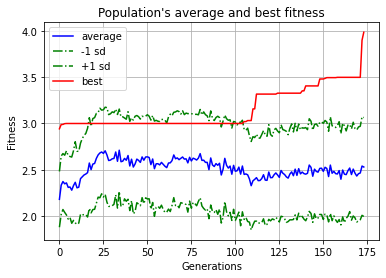

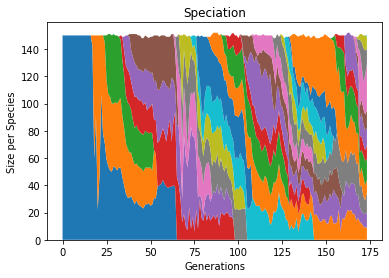

In [33]:
local_dir = os.path.dirname("neat/")
config_path = os.path.join(local_dir, 'neat_config_xor.txt')
run(config_path)

Key: 915
Fitness: 3.9783851752699815
Nodes:
	0 DefaultNodeGene(key=0, bias=-0.8222862709688838, response=1.0, activation=sigmoid, aggregation=sum)
	2641 DefaultNodeGene(key=2641, bias=-1.7877418356486396, response=1.0, activation=sigmoid, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-2, 0), weight=-0.9244516571929668, enabled=True)
	DefaultConnectionGene(key=(-2, 2641), weight=1.7211339136868429, enabled=True)
	DefaultConnectionGene(key=(-1, 0), weight=1.2826548449384207, enabled=True)
	DefaultConnectionGene(key=(-1, 2641), weight=-0.9728138367496404, enabled=True)
	DefaultConnectionGene(key=(2641, 0), weight=9.937774165689545, enabled=True)


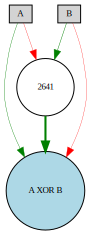

In [37]:
# Test
config_file = os.path.join(local_dir, 'neat_config_xor.txt')
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     config_file)
node_names = {-1: 'A', -2: 'B', 0: 'A XOR B'}

p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-139')
res = p.run(eval_genomes, 10)

print(res)

draw_net(config, res, True, node_names=node_names)